# MODELING TRAFFIC-DENSTIY OF THE CITY OF VIENNA
<i> Part 2: Constrained Optimization</i>
***

In this project I attempt to model the traffic-density for the City of Vienna solely based on publicly available data.<br><br>
<b>Data Sources:</b> 
- <u>Road network:</u> The official road network from (https://www.data.gv.at/) consists of information on ~30000 street segments and its respective geolocation and street-type.
- <u>Uber rides:</u> Information on Uber rides per City can be accessed at (https://movement.uber.com/). Uber is splitting the City of Vienna into 1370 subdistricts where travel-time between these starting & ending-areas is reported. Additional categorical information about weekdays or time of the day are available.

<b>Approach:</b><br><br>
<u>Part 1: Simulating Paths</u>
<ul>
    <li>Initialize a network graph consisting of all recorded streets of the City of Vienna</li>
    <li>Map maximum speed-limit to each network edge dependent on its street-type</li>
    <li>Calculate the shortest path of streets between pairs of start/end-nodes in the network</li>
    <li>Collect shortest path information for every start/end combination observed in the set of Uber rides</li>
</ul>

<u>Part 2: Constrained Optimization</u>
<ul>
    <li>Frame a constrained optimiziation problem to derive a "traffic-coefficient" per each area, representing its traffic-density</li>
    <li>Analyze traffic-density per area during different times of the day</li>

<img src="../artifacts/img/cover.jpg" alt="Drawing" style="width: 800px;"/><br>

<center>
    Photo by <a href="https://unsplash.com/@ahmgeek?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ahmad Tolba</a> on <a href="https://unsplash.com/s/photos/vienna-cars?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
   </center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Imports-&amp;-Settings" data-toc-modified-id="1-Imports-&amp;-Settings-1">1 Imports &amp; Settings</a></span></li><li><span><a href="#2-Data" data-toc-modified-id="2-Data-2">2 Data</a></span><ul class="toc-item"><li><span><a href="#2.1-Paths" data-toc-modified-id="2.1-Paths-2.1">2.1 Paths</a></span></li><li><span><a href="#2.2-Areas" data-toc-modified-id="2.2-Areas-2.2">2.2 Areas</a></span></li><li><span><a href="#2.3-Coefficients" data-toc-modified-id="2.3-Coefficients-2.3">2.3 Coefficients</a></span></li></ul></li><li><span><a href="#3-Optimization" data-toc-modified-id="3-Optimization-3">3 Optimization</a></span></li><li><span><a href="#4-Model-Evaluation" data-toc-modified-id="4-Model-Evaluation-4">4 Model Evaluation</a></span></li><li><span><a href="#5-Visuals" data-toc-modified-id="5-Visuals-5">5 Visuals</a></span><ul class="toc-item"><li><span><a href="#5.1-Coefficients" data-toc-modified-id="5.1-Coefficients-5.1">5.1 Coefficients</a></span></li><li><span><a href="#5.2-Traffic-Density" data-toc-modified-id="5.2-Traffic-Density-5.2">5.2 Traffic Density</a></span></li><li><span><a href="#5.3-Traffic-Speed" data-toc-modified-id="5.3-Traffic-Speed-5.3">5.3 Traffic Speed</a></span></li></ul></li><li><span><a href="#6-Scenario-Analysis" data-toc-modified-id="6-Scenario-Analysis-6">6 Scenario Analysis</a></span><ul class="toc-item"><li><span><a href="#6.1-Load-Coefficients" data-toc-modified-id="6.1-Load-Coefficients-6.1">6.1 Load Coefficients</a></span></li><li><span><a href="#6.2-Distribution-of-Coefficients" data-toc-modified-id="6.2-Distribution-of-Coefficients-6.2">6.2 Distribution of Coefficients</a></span></li><li><span><a href="#6.3-Comparison-by-Area" data-toc-modified-id="6.3-Comparison-by-Area-6.3">6.3 Comparison by Area</a></span></li></ul></li></ul></div>

### 1 Imports & Settings
***

In [12]:
import time
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Polygon
from scipy.optimize import minimize
from shapely.geometry import Polygon as Centroid
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys

root = os.environ['HOME']+"/private/vienna-traffic-density/"
sys.path.append(root)

import params.config as conf

### 2. Model Evaluation
***

In [3]:
X = pd.read_csv(os.path.join(conf.root_output, "X.csv"))
y = pd.read_csv(os.path.join(conf.root_output, "y.csv")).squeeze()
meta = pd.read_csv(os.path.join(conf.root_output, "meta.csv"))

X.index.name = "path"
X.columns.name = "areas"

In [4]:
# Drop areas that are outside of borders of Vienna
outer_areas = ["1365", "1366", "1367", "1368", "1369", "1370"]
X.drop(columns=outer_areas, errors="ignore", inplace=True)

# Train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Number of observations in train & test set
n_train = len(X_train)
n_test  = len(X_test)
n_coefs = X.shape[1]

# Initialize coefficients
coefs_init = np.random.normal(loc=0.20, scale=0.04, size=n_coefs)

In [5]:
# Areas where no path had a time measurement (all zero)
empty_areas = X_train.eq(0).all(axis=0)
empty_areas = empty_areas[empty_areas].index

# Areas where at least one path has are time measurement (is non-zero)
visited_areas = X_train.ne(0).any(axis=0)
visited_areas = visited_areas[visited_areas].index

### 3 Optimization
***

In [6]:
# Boundaries for coefficients
bounds = [(0.03,0.72)] * n_coefs

# Store coefficients at each iteration in list
coefs_all = coefs_init.copy()

# Counter for iterations
iteration = 0

In [7]:
def loss_func(coefs, **kwargs):
    """
    A function that returns the residual squared error, based on a set of coefs
    
    Parameters
    ----------
    coefs : pd.Series
    test : bool (optional)
    """
    
    if "test" in kwargs:
        if kwargs["test"] is True:
            X, y, n = X_test, y_test, n_test
        
    else:
        X, y, n = X_train, y_train, n_train
    
    est  = np.dot(X, coefs)
    err  = np.sum(np.power(est-y, 2))
    rmse = np.sqrt(err/n)
    return rmse

def callback_func(coefs_i):
    """A function that prints runtime at each iteration"""
    
    global start_time, coefs_all, iteration
    
    iteration += 1

    rmse = loss_func(coefs_i)
    coefs_all = np.vstack((coefs_all, coefs_i))
    
    run_time = (time.time() - start_time)/60
    print (f"Iter: {str(iteration)} has {rmse:.4f} RMSE after {run_time:.2f} minutes")

In [8]:
# Run optimization
start_time = time.time()

result = minimize(
    fun=loss_func, 
    x0=coefs_init,
    bounds=bounds,
    callback=callback_func
)

Iter: 1 has 312.7258 RMSE after 0.09 minutes
Iter: 2 has 305.6842 RMSE after 0.11 minutes
Iter: 3 has 299.2156 RMSE after 0.12 minutes
Iter: 4 has 298.1389 RMSE after 0.14 minutes
Iter: 5 has 297.8017 RMSE after 0.16 minutes
Iter: 6 has 297.7272 RMSE after 0.17 minutes
Iter: 7 has 297.7018 RMSE after 0.19 minutes
Iter: 8 has 297.6879 RMSE after 0.23 minutes
Iter: 9 has 297.6818 RMSE after 0.25 minutes
Iter: 10 has 297.6784 RMSE after 0.29 minutes
Iter: 11 has 297.6744 RMSE after 0.31 minutes


In [9]:
# Optimal coefficients
coefs = pd.Series(data=result.x, index=X.columns, name="coefs")
coefs_df = pd.DataFrame(data=coefs_all, columns=X.columns).T

n_it  = result.nit
rmse_train = result.fun
rmse_test = loss_func(coefs=coefs, test=True)

print (f"Train RMSE: {rmse_train:.4f}")
print (f"Test RMSE: {rmse_test:.4f}")

Train RMSE: 297.6744
Test RMSE: 308.7661


### 5 Visuals
***

In [ ]:
import pickle

filepath = os.path.join(conf.root_output, "areas.pickle")

with open(filepath, 'rb') as f:
    areas = pickle.load(f)

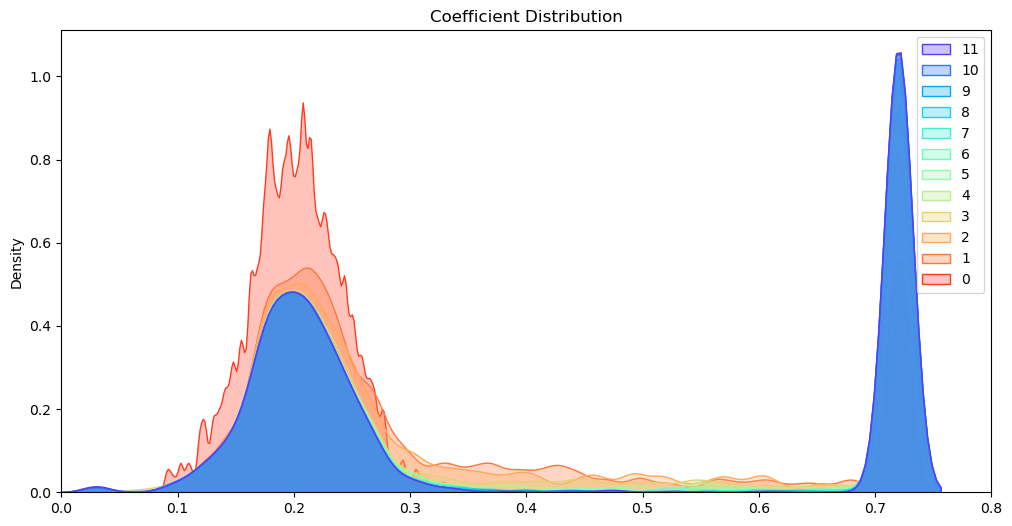

In [14]:
plt.figure(figsize=(12,6))
sns.kdeplot(
    data=coefs_df, 
    hue_order=coefs_df.columns[::-1], 
    bw_adjust=0.2, 
    palette="rainbow", 
    shade=True, 
    alpha=0.3, 
    lw=1,
    label=coefs_df.columns
)
plt.xlim(0,0.8)
plt.title("Coefficient Distribution")
plt.show()

#### 5.2 Traffic Density

In [15]:
# Instantiate network graph
Vienna = nx.Graph()

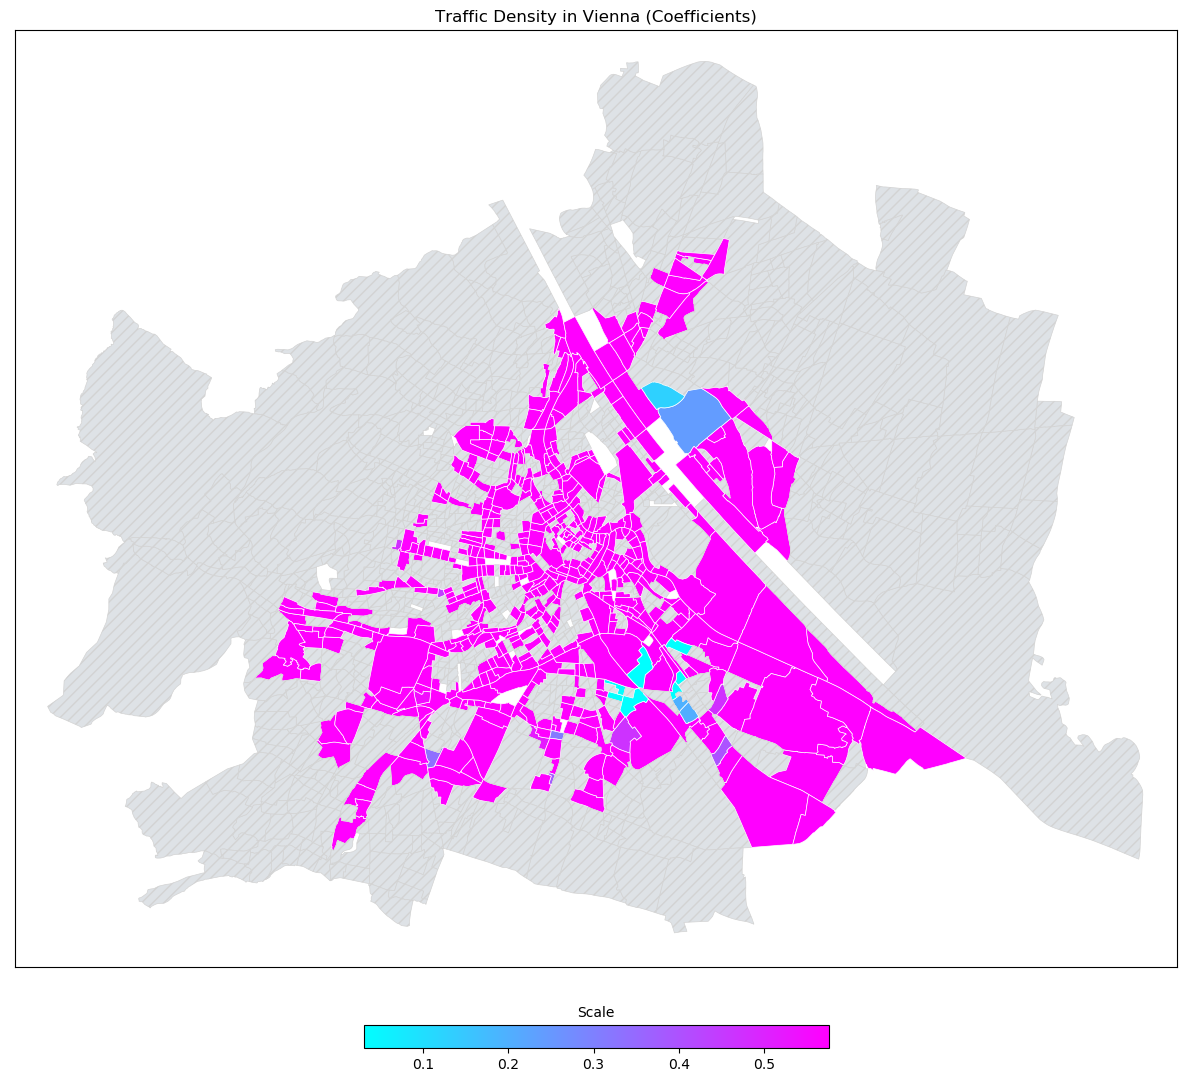

In [18]:
# Get colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=np.min(coefs), vmax=np.max(coefs)*0.8)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Coefficients)", fontsize=12)

for key,val in areas.polygons.items():
    
    # Skipping plotting for outer areas
    if key in outer_areas:
        continue
    
    # Plot areas with density data
    elif key in visited_areas:
        # idx = int(key)-1
        density = norm(coefs[key])

        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="white",
            linewidth=0.5))
    
    # Plot areas without density data
    elif key in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5))
        
        # x_center, y_center = Centroid(val).centroid.coords[0]
        # ax.text(x=x_center, y=y_center, s=key, ha="center")

cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Scale", fontsize=10)
plt.savefig(conf.root_img+"/coefs.png")
plt.show()

#### 5.3 Traffic Speed

In [19]:
def coef_kmh(coefs):
    """A function that converts coefficients from s/m into km/h."""
    
    mps = 1/coefs
    kmh = mps/1000*3600
    
    return kmh

In [21]:
kmh = coef_kmh(coefs=coefs)

In [22]:
# Get colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=np.min(kmh), vmax=np.max(kmh)*0.9)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

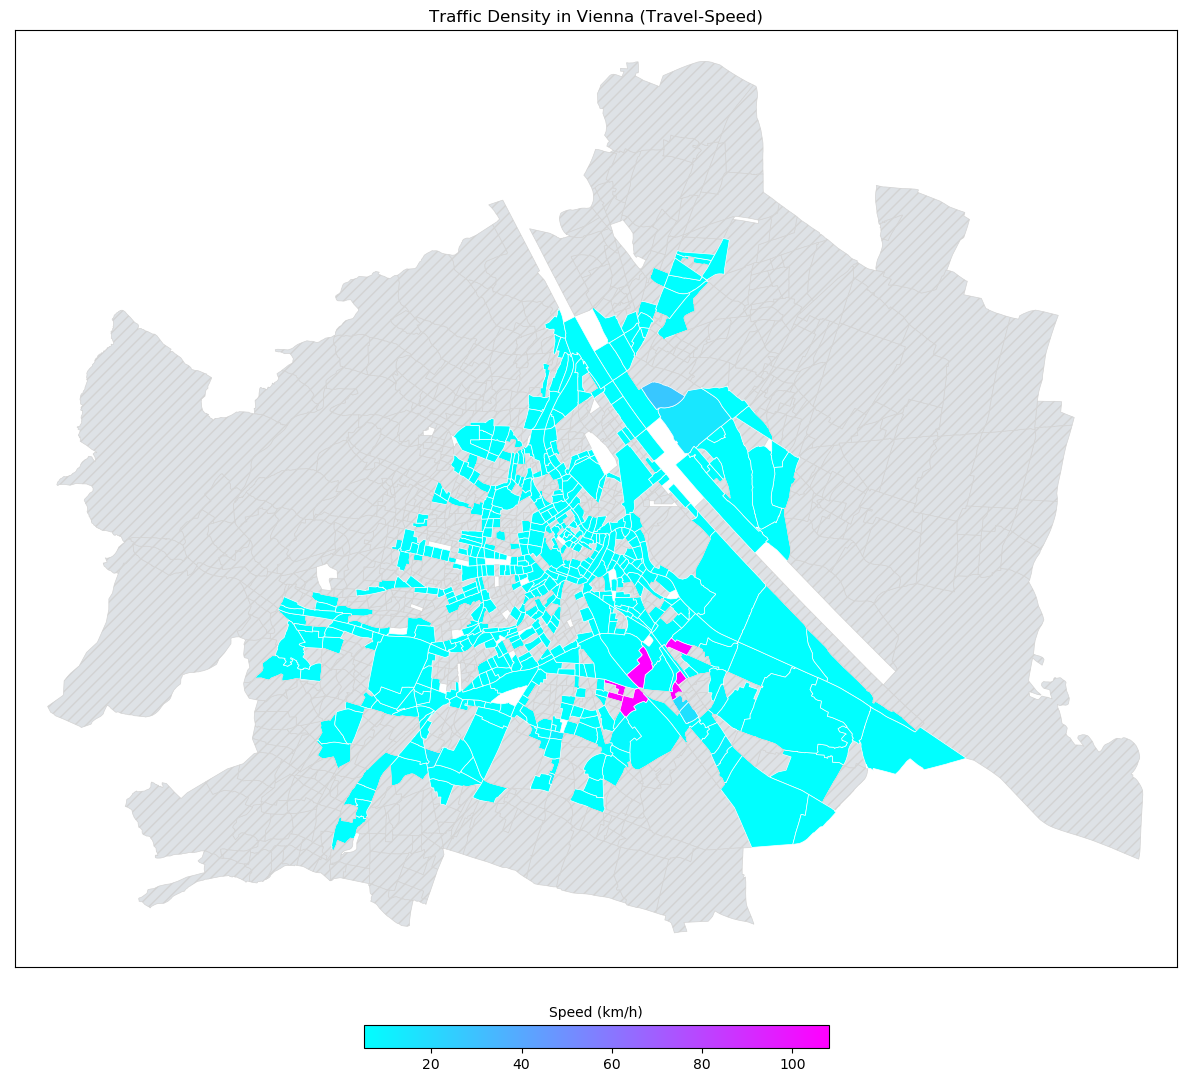

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

# Set axis limits for figure
ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Travel-Speed)", fontsize=12)

for key,val in areas.polygons.items():
    
    # Skipping plotting for outer areas
    if key in outer_areas:
        continue
    
    # Plot areas with density data
    elif key in visited_areas:
        density = norm(kmh[key])

        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="white",
            linewidth=0.5))
    
    # Plot areas without density data
    elif key in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5))

# Add colormap
cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Speed (km/h)", fontsize=10)
plt.savefig(conf.root_img+"/speed.png")
plt.show()